## Far-Field Forcing
How do remote SSTs and SLP affect the Amundsen Sea?

In [ ]:
#Import relevant functions
from functions.loading_and_processing_data import loadMITgcmData, loadTimeSeriesData, loadPACEData, detrend_and_average_MITgcmData#, read_all_data
from functions.composite_maps import createCompositeMap, createVelocityCompositeMap, defineEvents, findEvents, createCompositeMap_2, workflowCompositeMap
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xskillscore as xs

In [2]:
%%capture
#Load SST and SLP data from PACE (Yes, SLP is called PSL...) and basal mass loss
members='all'
PSL=loadPACEData(var='PSL', members=members)
SST=loadPACEData(var='SST', members=members) 
melt=loadTimeSeriesData(filename='timeseries_final', members=members, kind='old')

melt['time']=melt.indexes['time'].to_datetimeindex()
SST['time']=SST.indexes['time'].to_datetimeindex()
PSL['time']=PSL.indexes['time'].to_datetimeindex()

In [3]:
%%capture
#Detrend all the data
SST_dt=detrend_and_average_MITgcmData(SST, 'SST', window=1)
PSL_dt=detrend_and_average_MITgcmData(PSL, 'PSL', window=1)
melt_dt=detrend_and_average_MITgcmData(melt, 'dotson_to_cosgrove_massloss', window=1)
meltrm=detrend_and_average_MITgcmData(melt, 'dotson_to_cosgrove_massloss', window=60)

In [4]:
# #Simple Composite Map: Computation
# PSL_dt=PSL_dt.where(PSL_dt!=0, drop=True)
# PSLmean1=PSL_dt.where(meltrm>meltrm.quantile(0.9)).mean(dim=['time', 'ens'])
# PSLmean2=PSL_dt.where(meltrm<meltrm.quantile(0.1)).mean(dim=['time', 'ens'])

# SST_dt=SST_dt.where(SST_dt!=0, drop=True)
# SSTmean1=SST_dt.where(meltrm>meltrm.quantile(0.9)).mean(dim=['time', 'ens'])
# SSTmean2=SST_dt.where(meltrm<meltrm.quantile(0.1)).mean(dim=['time', 'ens'])

In [5]:
# #Simple Composite Map: Visualisation
# def cartopyComposite(mean1, mean2, unit='Pa', title='Composite of Sea Level Air Pressure in PACE'):
#     import cartopy.crs as ccrs
#     plt.rcParams.update({'font.size': 20})
#     fig=plt.figure(figsize=(20,10))
#     ax = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180.0))
#     #data_dt[var]=data_dt[var].where(data_dt[var]!=0)
#     #divnorm = colors.TwoSlopeNorm(vcenter=0, vmin=np.nanpercentile(mean1, 1), vmax=np.nanpercentile(mean1, 99))
#     if 'Pa' in unit:
#         img=ax.pcolormesh(mean1.lon, mean1.lat, 
#                       mean1.values, 
#                       cmap='seismic', transform=ccrs.PlateCarree(), vmin=-80, vmax=80)
#     elif 'K' in unit:
#         img=ax.scatter(mean1.ULONG.to_numpy().flatten(), mean1.ULAT.to_numpy().flatten(), s=0.3,
#                       c=mean1.isel(z_t=0).to_numpy().flatten(), 
#                       cmap='seismic', transform=ccrs.PlateCarree(), vmin=-0.4, vmax=0.4)
#     ax.set_facecolor('grey')
#     plt.colorbar(img, label=unit, pad=0.10, ax=ax, extend='both')
#     ax.coastlines()
#     ax.set_title(title+'\n melt>90th percentile')
#     ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
    
#     ax = plt.subplot(212, projection=ccrs.PlateCarree(central_longitude=180.0))
#     #data_dt[var]=data_dt[var].where(data_dt[var]!=0)
#     #divnorm = colors.TwoSlopeNorm(vcenter=0, vmin=np.nanpercentile(mean1, 1), vmax=np.nanpercentile(mean1, 99))
#     if 'Pa' in unit:
#         img=ax.pcolormesh(mean2.lon, mean2.lat, 
#                       mean2.values, 
#                       cmap='seismic', transform=ccrs.PlateCarree(), vmin=-80, vmax=80)
#     elif 'K' in unit:
#         img=ax.scatter(mean2.ULONG.to_numpy().flatten(), mean2.ULAT.to_numpy().flatten(), s=0.3,
#                       c=mean2.isel(z_t=0).to_numpy().flatten(), 
#                       cmap='seismic', transform=ccrs.PlateCarree(), vmin=-0.4, vmax=0.4)
        
#     ax.set_facecolor('grey')
#     plt.colorbar(img, label=unit, pad=0.10, ax=ax, extend='both')
#     ax.coastlines()
#     ax.set_title('melt<10th percentile')
#     ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
    
#     #fig.suptitle('          '+title)
#     plt.subplots_adjust(hspace=0.5, top=0.8)
#     plt.show()
#     return fig


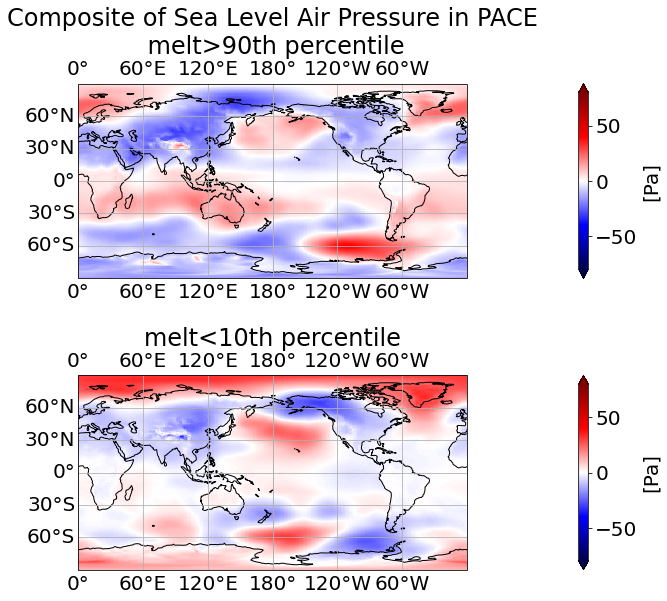

In [65]:
# fig=cartopyComposite(mean1=PSLmean1, mean2=PSLmean2, unit='[Pa]')
# fig.savefig('../03_output/composite/composite_PSL_PACE_full.png')

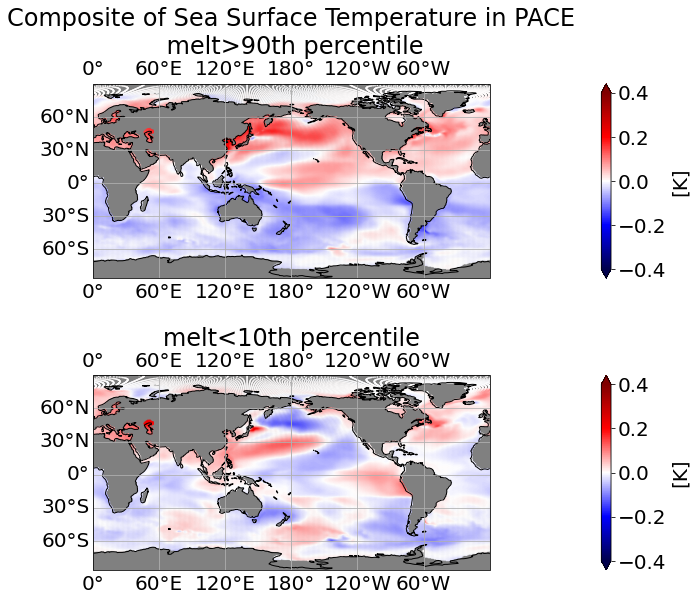

In [10]:
# fig=cartopyComposite(mean1=SSTmean1, mean2=SSTmean2, unit='[K]', title='Composite of Sea Surface Temperature in PACE')
# fig.savefig('../03_output/composite/composite_SST_PACE_full.png')

## How well do different climatic indices correlate with the melt and wind?

In [6]:
# def interpolateSST(SST, xgrid, ygrid, time):
#     from scipy.interpolate import griddata
    
#     # data coordinates and values
#     x = SST.sel(ens=0).ULONG.to_numpy().flatten()
#     y = SST.sel(ens=0).ULAT.to_numpy().flatten()
    
#     # target grid to interpolate to
#     xi,yi = np.meshgrid(xgrid,ygrid)
    
#     zfinal=np.zeros((len(time), np.shape(xi)[0], np.shape(xi)[1],))
#     #Perform this for every time step...
#     for i in range(3):#len(time)):
#         z = SST.isel(ens=0, time=i).to_numpy().flatten()
#         # interpolate
#         zfinal[i,:,:] = griddata((x,y),z,(xi,yi),method='linear')
        
#     # plot
#     fig = plt.figure()
#     ax = fig.add_subplot(211)
#     plt.pcolor(xi,yi,zi, cmap='seismic',  vmin=-0.4, vmax=0.4)
#     plt.xlabel('xi',fontsize=16)
#     plt.ylabel('yi',fontsize=16)

#     ax = fig.add_subplot(212)
#     img=ax.scatter(SST_dt.ULONG.to_numpy().flatten(), SST_dt.ULAT.to_numpy().flatten(), s=0.3,
#                           c=SST_dt.isel(ens=0, time=0, z_t=0).to_numpy().flatten(), 
#                           cmap='seismic',  vmin=-0.4, vmax=0.4)
#     plt.xlabel('xi',fontsize=16)
#     plt.ylabel('yi',fontsize=16)

#     SST_new=xr.DataArray(data=zfinal,
#                         dims=['time', 'lat', 'lon'],
#                         coords=dict(
#                         lon=xgrid,
#                         lat=ygrid,
#                         time=time)                        
#                         )
#     return SST_new

# def binmeanSST(SST, xgrid, ygrid, time, ens):
#     from scipy.stats import binned_statistic_2d
    
#     # data coordinates and values
#     x = SST.sel(ens=0).ULONG.to_numpy().flatten()
#     y = SST.sel(ens=0).ULAT.to_numpy().flatten()
    
#     # target grid to interpolate to
#     x_bins=xgrid
#     y_bins=ygrid
    
#     zfinal=np.zeros((len(time), len(ygrid)-1, len(xgrid)-1, len(ens)))
#     #Perform this for every time step...
#     for j in ens:
#         print('Starting with Ens: '+str(j))
#         for i in range(len(time)):
#             z = SST.isel(ens=j, time=i).to_numpy().flatten()
#             # bin
#             ret = binned_statistic_2d(x, y, z, statistic=np.mean, bins=[x_bins, y_bins])
#             zfinal[i,:,:, j] = ret.statistic.T
        
#     # plot
#     fig = plt.figure()
#     ax = fig.add_subplot(211)
#     plt.pcolor(xi,yi,zi, cmap='seismic',  vmin=-0.4, vmax=0.4)
#     plt.xlabel('xi',fontsize=16)
#     plt.ylabel('yi',fontsize=16)

#     ax = fig.add_subplot(212)
#     img=ax.scatter(SST_dt.ULONG.to_numpy().flatten(), SST_dt.ULAT.to_numpy().flatten(), s=0.3,
#                           c=SST_dt.isel(ens=0, time=0, z_t=0).to_numpy().flatten(), 
#                           cmap='seismic',  vmin=-0.4, vmax=0.4)
#     plt.xlabel('xi',fontsize=16)
#     plt.ylabel('yi',fontsize=16)

#     SST_new=xr.DataArray(data=zfinal,
#                         dims=['time', 'lat', 'lon', 'ens'],
#                         coords=dict(
#                         lon=(xgrid[1:].values+xgrid[:-1].values)/2,
#                         lat=(ygrid[1:].values+ygrid[:-1].values)/2,
#                         ens=ens,
#                         time=time)                        
#                         )
#     return SST_new

In [ ]:
# SST_new=binmeanSST(SST['SST'], xgrid=PSL.lon, ygrid=PSL.lat, time=PSL.time, ens=np.arange(20))

Starting with Ens: 0


#### Read or Compute Indices

In [11]:
#WestPacificSSTs (following Thomas et al., 2015):
#Note: this was already computed in read indices and saved, in order to save time.

# WPSST=SST_dt.where((SST_dt.ULONG>=120) & (SST_dt.ULONG<=160), drop=True)
# WPSST=WPSST.where((WPSST.ULAT>=0) & (WPSST.ULAT<=15), drop=True)
# WPSST=WPSST.mean(dim=['nlat', 'nlon', 'z_t'])

# WPSST=SST_new.sel(lon=slice(120,160), lat=slice(0,15))
# weights = np.cos(np.deg2rad(WPSST.lat))
# WPSST=WPSST.weighted(weights)
# WPSST=WPSST.mean(dim=['lat', 'lon'])

WPSST=xr.open_dataarray('../02_data/indices/WPSST_PACE.nc')

In [12]:
#IPO (following Henley et al., 2015):
#Note: this was already computed in read indices and saved, in order to save time.

# region1=SST_dt.where((SST_dt.ULONG>=140) & (SST_dt.ULONG<=360-140), drop=True)
# region1=region1.where((region1.ULAT>=25) & (region1.ULAT<=45), drop=True)
# region1=region1.mean(dim=['nlat', 'nlon', 'z_t'])

# region2=SST_dt.where((SST_dt.ULONG>=170) & (SST_dt.ULONG<=360-90), drop=True)
# region2=region2.where((region2.ULAT>=-10) & (region2.ULAT<=10), drop=True)
# region2=region2.mean(dim=['nlat', 'nlon', 'z_t'])

# region3=SST_dt.where((SST_dt.ULONG>=150) & (SST_dt.ULONG<=360-160), drop=True)
# region3=region3.where((region3.ULAT>=-50) & (region3.ULAT<=-15), drop=True)
# region3=region3.mean(dim=['nlat', 'nlon', 'z_t'])


# region1=SST_new.sel(lon=slice(140, 360-140), lat=slice(25, 45))
# region1=region1.groupby('time.month')-region1.sel(time=slice('1971', '2000')).groupby('time.month').mean()
# weights = np.cos(np.deg2rad(region1.lat))
# region1=region1.weighted(weights)
# region1=region1.mean(dim=['lat', 'lon'])

# region2=SST_new.sel(lon=slice(170, 360-90), lat=slice(-10, 10))
# region2=region2.groupby('time.month')-region2.sel(time=slice('1971', '2000')).groupby('time.month').mean()
# weights = np.cos(np.deg2rad(region2.lat))
# region2=region2.weighted(weights)
# region2=region2.mean(dim=['lat', 'lon'])

# region3=SST_new.sel(lon=slice(150, 360-160), lat=slice(-50, -15))
# region3=region3.groupby('time.month')-region3.sel(time=slice('1971', '2000')).groupby('time.month').mean()
# weights = np.cos(np.deg2rad(region3.lat))
# region3=region3.weighted(weights)
# region3=region3.mean(dim=['lat', 'lon'])

# IPO=region2-(region1+region3)/2

IPO=xr.open_dataarray('../02_data/indices/IPO_PACE.nc')

In [13]:
#SOI; coordinates based on: https://www.pmel.noaa.gov/pubs/outstand/harr1647/troup.shtml
#calculation based on: https://www.ncei.noaa.gov/access/monitoring/enso/soi; semi-correct

tahiti=PSL.sel(lon=slice(360-151,360-149), lat=slice(-18.5, -17.5))
weights = np.cos(np.deg2rad(tahiti.lat))
tahiti=tahiti.weighted(weights)
tahiti=tahiti.mean(dim=['lat', 'lon'])
tahiti=tahiti-tahiti.sel(time=slice('1981', '2010')).mean()

darwin=PSL.sel(lon=slice(130,131), lat=slice(-13, -12))
weights = np.cos(np.deg2rad(darwin.lat))
darwin=darwin.weighted(weights)
darwin=darwin.mean(dim=['lat', 'lon'])
darwin=darwin-darwin.sel(time=slice('1981', '2010')).mean()

tahiti=tahiti/tahiti.std(dim='time')
darwin=darwin/darwin.std(dim='time')

td=tahiti-darwin

SOI=(tahiti-darwin)/td.std(dim='time')
SOI=SOI['PSL']

# darwin=SST_dt.where((SST_dt.ULONG>=130) & (SST_dt.ULONG<=131), drop=True)
# darwin=darwin.where((tahiti.ULAT>=-18) & (tahiti.ULAT<=-17), drop=True)
# darwin=darwin.mean(dim=['nlat', 'nlon', 'z_t'])

In [14]:
#AMO
#Roughly following https://psl.noaa.gov/data/timeseries/AMO/
# AMO=SST_dt.where((SST_dt.ULONG>=360-70) & (SST_dt.ULONG<=360), drop=True)
# AMO=AMO.where((AMO.ULAT>=0) & (AMO.ULAT<=70), drop=True)
# AMO=AMO.mean(dim=['nlat', 'nlon', 'z_t'])

In [15]:
#ASL; based on: https://scotthosking.com/asl_index; correct
ASL=PSL.sel(lon=slice(170, 298), lat=slice(-80, -60))['PSL']
ASLcp=ASL.min(dim=['lat', 'lon'])
ASLlon=ASL.idxmin('lat').idxmin('lon')
ASLlat=ASL.idxmin('lon').idxmin('lat')
#ASLlat=ASL.argmin('lat')

In [16]:
#SAM; based on: https://psl.noaa.gov/data/20thC_Rean/timeseries/monthly/SAM/; correct
PSL40=PSL.interp(lat=-40).mean(dim='lon')
PSL65=PSL.interp(lat=-65).mean(dim='lon')
PSL40_st=(PSL40.groupby('time.month')-PSL40.sel(time=slice('1981','2010')).groupby('time.month').mean()).groupby('time.month')/PSL40.sel(time=slice('1981','2010')).groupby('time.month').std()
PSL65_st=(PSL65.groupby('time.month')-PSL65.sel(time=slice('1981','2010')).groupby('time.month').mean()).groupby('time.month')/PSL65.sel(time=slice('1981','2010')).groupby('time.month').std()
SAM=PSL40_st-PSL65_st
SAM=SAM['PSL']

/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing metho

In [17]:
%%capture
#Load wind data (to correlate with)
wind=loadTimeSeriesData(filename='timeseries_final', members=members, kind='old')
wind['time']=wind.indexes['time'].to_datetimeindex()
wind_dt=detrend_and_average_MITgcmData(wind, 'amundsen_shelf_break_uwind_avg', window=1)

In [18]:
# IPO_dt=detrend_and_average_MITgcmData(IPO.to_dataset(name='IPO'), var='IPO', window=1)
# cumulIPO=IPO_dt.cumsum(dim='time')

In [22]:
#Now, correlate with the ice shelf basal mass loss.
#Compute correlation coefficients:
ASLcp_corr=xr.corr(melt_dt.rolling(time=60, center=True).mean(),\
       ASLcp.rolling(time=60, center=True).mean(),\
       dim='time')

ASLlon_corr=xr.corr(melt_dt.rolling(time=60, center=True).mean(),\
       ASLlon.rolling(time=60, center=True).mean(),\
       dim='time')

ASLlat_corr=xr.corr(melt_dt.rolling(time=60, center=True).mean(),\
       ASLlat.rolling(time=60, center=True).mean(),\
       dim='time')

IPO_corr=xr.corr(melt_dt.rolling(time=60, center=True).mean(),\
       IPO.rolling(time=60, center=True).mean(),\
       dim='time')

SOI_corr=xr.corr(melt_dt.rolling(time=60, center=True).mean(),\
       SOI.rolling(time=60, center=True).mean(),\
       dim='time')

SAM_corr=xr.corr(melt_dt.rolling(time=60, center=True).mean(),\
       SAM.rolling(time=60, center=True).mean(),\
       dim='time')

WPSST_corr=xr.corr(melt_dt.rolling(time=60, center=True).mean(),\
       WPSST.rolling(time=60, center=True).mean(),\
       dim='time')

# cumulIPO_corr=xr.corr(melt_dt.rolling(time=60, center=True).mean(),\
#        cumulIPO.rolling(time=60, center=True).mean(),\
#        dim='time')

# AMO_corr=xr.corr(melt_dt.rolling(time=60, center=True).mean(),\
#        AMO.rolling(time=60, center=True).mean(),\
#        dim='time')

#Stack data for plotting
data_melt=np.vstack([ASLcp_corr, ASLlon_corr, ASLlat_corr, IPO_corr, SOI_corr, SAM_corr, WPSST_corr][::-1])
data_melt=data_melt.T
names=['ASL CP', 'ASL \nLon', 'ASL \nLat', 'IPO', 'SOI', 'SAM', 'WPSST'][::-1]


#Now, correlate with the shelf break zonal wind.
#Compute correlation coefficients:
ASLcp_corr=xr.corr(wind_dt.rolling(time=60, center=True).mean(),\
       ASLcp.rolling(time=60, center=True).mean(),\
       dim='time')

ASLlon_corr=xr.corr(wind_dt.rolling(time=60, center=True).mean(),\
       ASLlon.rolling(time=60, center=True).mean(),\
       dim='time')

ASLlat_corr=xr.corr(wind_dt.rolling(time=60, center=True).mean(),\
       ASLlat.rolling(time=60, center=True).mean(),\
       dim='time')

IPO_corr=xr.corr(wind_dt.rolling(time=60, center=True).mean(),\
       IPO.rolling(time=60, center=True).mean(),\
       dim='time')

SOI_corr=xr.corr(wind_dt.rolling(time=60, center=True).mean(),\
       SOI.rolling(time=60, center=True).mean(),\
       dim='time')

SAM_corr=xr.corr(wind_dt.rolling(time=60, center=True).mean(),\
       SAM.rolling(time=60, center=True).mean(),\
       dim='time')

WPSST_corr=xr.corr(wind_dt.rolling(time=60, center=True).mean(),\
       WPSST.rolling(time=60, center=True).mean(),\
       dim='time')

# cumulIPO_corr=xr.corr(wind_dt.rolling(time=60, center=True).mean(),\
#        cumulIPO.rolling(time=60, center=True).mean(),\
#        dim='time')

# AMO_corr=xr.corr(wind_dt.rolling(time=60, center=True).mean(),\
#        AMO.rolling(time=60, center=True).mean(),\
#        dim='time')

#Stack the data for plotting.
data_wind=np.vstack([IPO_corr, SOI_corr, ASLcp_corr, ASLlon_corr, ASLlat_corr,   SAM_corr, WPSST_corr][::-1])
data_wind=data_wind.T
names=['ASL\n CP', 'ASL \nLon', 'ASL \nLat', 'IPO', 'SOI', 'SAM', 'WPSST'][::-1]

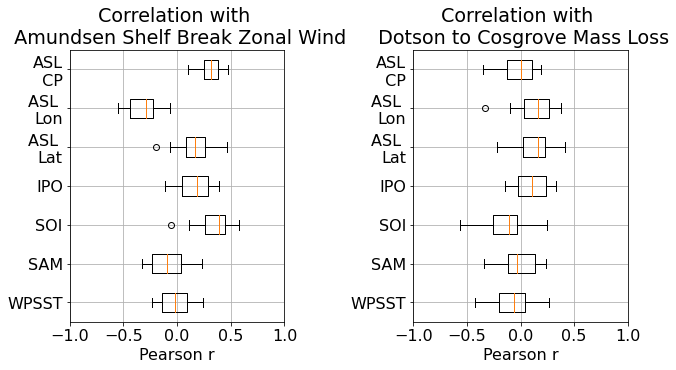

In [23]:
# plt.rcParams.update({'font.size': 16})

# plt.figure(figsize=(10,5))
# #plt.suptitle('Correlation Coefficients of Climatic Indices with Amundsen Shelf Variables')
# plt.subplot(1,2,2)
# plt.boxplot(data_melt, vert=False)
# plt.yticks(np.arange(len(names))+1, names)
# plt.grid()
# plt.title('Correlation with \n Dotson to Cosgrove Mass Loss')
# plt.xlabel('Pearson r')
# plt.xlim([-1,1])

# plt.subplot(1,2,1)
# plt.boxplot(data_wind, vert=False)
# plt.yticks(np.arange(len(names))+1, names)
# plt.grid()
# plt.title('Correlation with \n Amundsen Shelf Break Zonal Wind')
# plt.xlabel('Pearson r')
# plt.xlim([-1,1])

# plt.subplots_adjust(wspace=0.6)

# #plt.savefig('/data/hpcdata/users/grejan/mitgcm/03_output/other/correlations_climatic_indices.png')


(20, 7)
(20, 7)
7


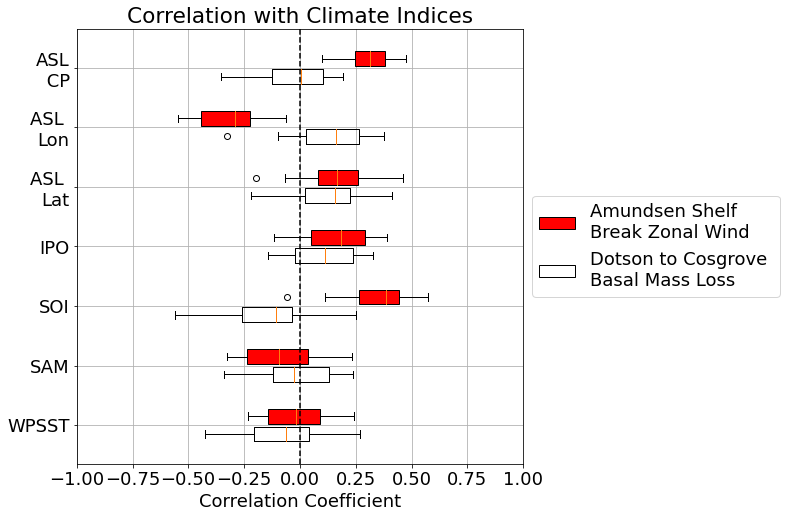

In [24]:
#Show Boxplot indicating spread of correlation coefficients between individual members.

plt.rcParams.update({'font.size': 18})

fig=plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
a=plt.boxplot(data_melt, positions=np.arange(len(names))+0.85, widths=0.25, vert=False)
b=plt.boxplot(data_wind, positions=np.arange(len(names))+1.15, widths=0.25, vert=False, patch_artist=True)
plt.yticks(np.arange(len(names))+1, names)
plt.grid()
plt.title('Correlation with Climate Indices')
plt.xlabel('Correlation Coefficient')
plt.xlim([-1,1])
plt.axvline(x = 0, color = 'k', ls='--')

# fill with colors
colors = ['r',]*len(names)
#for bplot in (bplot1, bplot2):
for patch, color in zip(b['boxes'], colors):
    patch.set_facecolor(color)

import matplotlib.patches as mpatches
white_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='Dotson to Cosgrove \nBasal Mass Loss')
red_patch = mpatches.Patch(facecolor='red', edgecolor='black', label='Amundsen Shelf \nBreak Zonal Wind')
lgd=plt.legend(handles=[red_patch, white_patch], loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig('/data/hpcdata/users/grejan/mitgcm/03_output/other/correlations_climatic_indices_1plot.png', \
            bbox_extra_artists=(lgd,), bbox_inches='tight')

### BONUS: How do indices act together with ENSO?

In [17]:
from sklearn import linear_model

In [173]:
def correlate_with_base_ind(base_ind='IPO'):
    ind={'IPO': IPO.rolling(time=60, center=True).mean(),
         'SOI': SOI.rolling(time=60, center=True).mean(),
         'ASLcp': ASLcp.rolling(time=60, center=True).mean(),
         'ASLlat': ASLlat.rolling(time=60, center=True).mean(),
         'ASLlon': ASLlon.rolling(time=60, center=True).mean(),
         'SAM': SAM.rolling(time=60, center=True).mean(),
         'WPSST': WPSST.rolling(time=60, center=True).mean()}

    corrs_melt={}
    corrs_wind={}
    

    for name in ind:
        corrs_melt[name]=[]
        corrs_wind[name]=[]
        for i in range(20):
            if name==base_ind:
                X1=np.array([ind[name].sel(ens=i).to_numpy()[30:-30]]).reshape(1,-1)
            else:
                X1=np.array([ind[base_ind].sel(ens=i).to_numpy()[30:-30], ind[name].sel(ens=i).to_numpy()[30:-30]])
            
            ymelt=melt_dt.sel(ens=i).rolling(time=60, center=True).mean().to_numpy()[30:-30]
            ywind=wind_dt.sel(ens=i).rolling(time=60, center=True).mean().to_numpy()[30:-30]
            
            regr = linear_model.LinearRegression()
            regr.fit(X=X1.T, y=ymelt)
            #corrs_melt[name]+=[np.corrcoef(regr.predict(X1.T), ymelt)[1,0]]
            corrs_melt[name]+=[regr.score(X=X1.T, y=ymelt)]
    
            regr = linear_model.LinearRegression()
            regr.fit(X=X1.T, y=ywind)
            corrs_wind[name]+=[regr.score(X=X1.T, y=ywind)]
    return corrs_wind, corrs_melt

['IPO' 'SOI' 'ASLcp' 'ASLlat' 'ASLlon' 'SAM' 'WPSST']
['IPO only' 'IPO \n with SOI' 'IPO \n with ASLcp' 'IPO \n with ASLlat'
 'IPO \n with ASLlon' 'IPO \n with SAM' 'IPO \n with WPSST']
['IPO' 'SOI' 'ASLcp' 'ASLlat' 'ASLlon' 'SAM' 'WPSST']
['SOI \n with IPO' 'SOI only' 'SOI \n with ASLcp' 'SOI \n with ASLlat'
 'SOI \n with ASLlon' 'SOI \n with SAM' 'SOI \n with WPSST']
['IPO' 'SOI' 'ASLcp' 'ASLlat' 'ASLlon' 'SAM' 'WPSST']
['SAM \n with IPO' 'SAM \n with SOI' 'SAM \n with ASLcp'
 'SAM \n with ASLlat' 'SAM \n with ASLlon' 'SAM only' 'SAM \n with WPSST']
['IPO' 'SOI' 'ASLcp' 'ASLlat' 'ASLlon' 'SAM' 'WPSST']
['ASLlat \n with IPO' 'ASLlat \n with SOI' 'ASLlat \n with ASLcp'
 'ASLlat only' 'ASLlat \n with ASLlon' 'ASLlat \n with SAM'
 'ASLlat \n with WPSST']


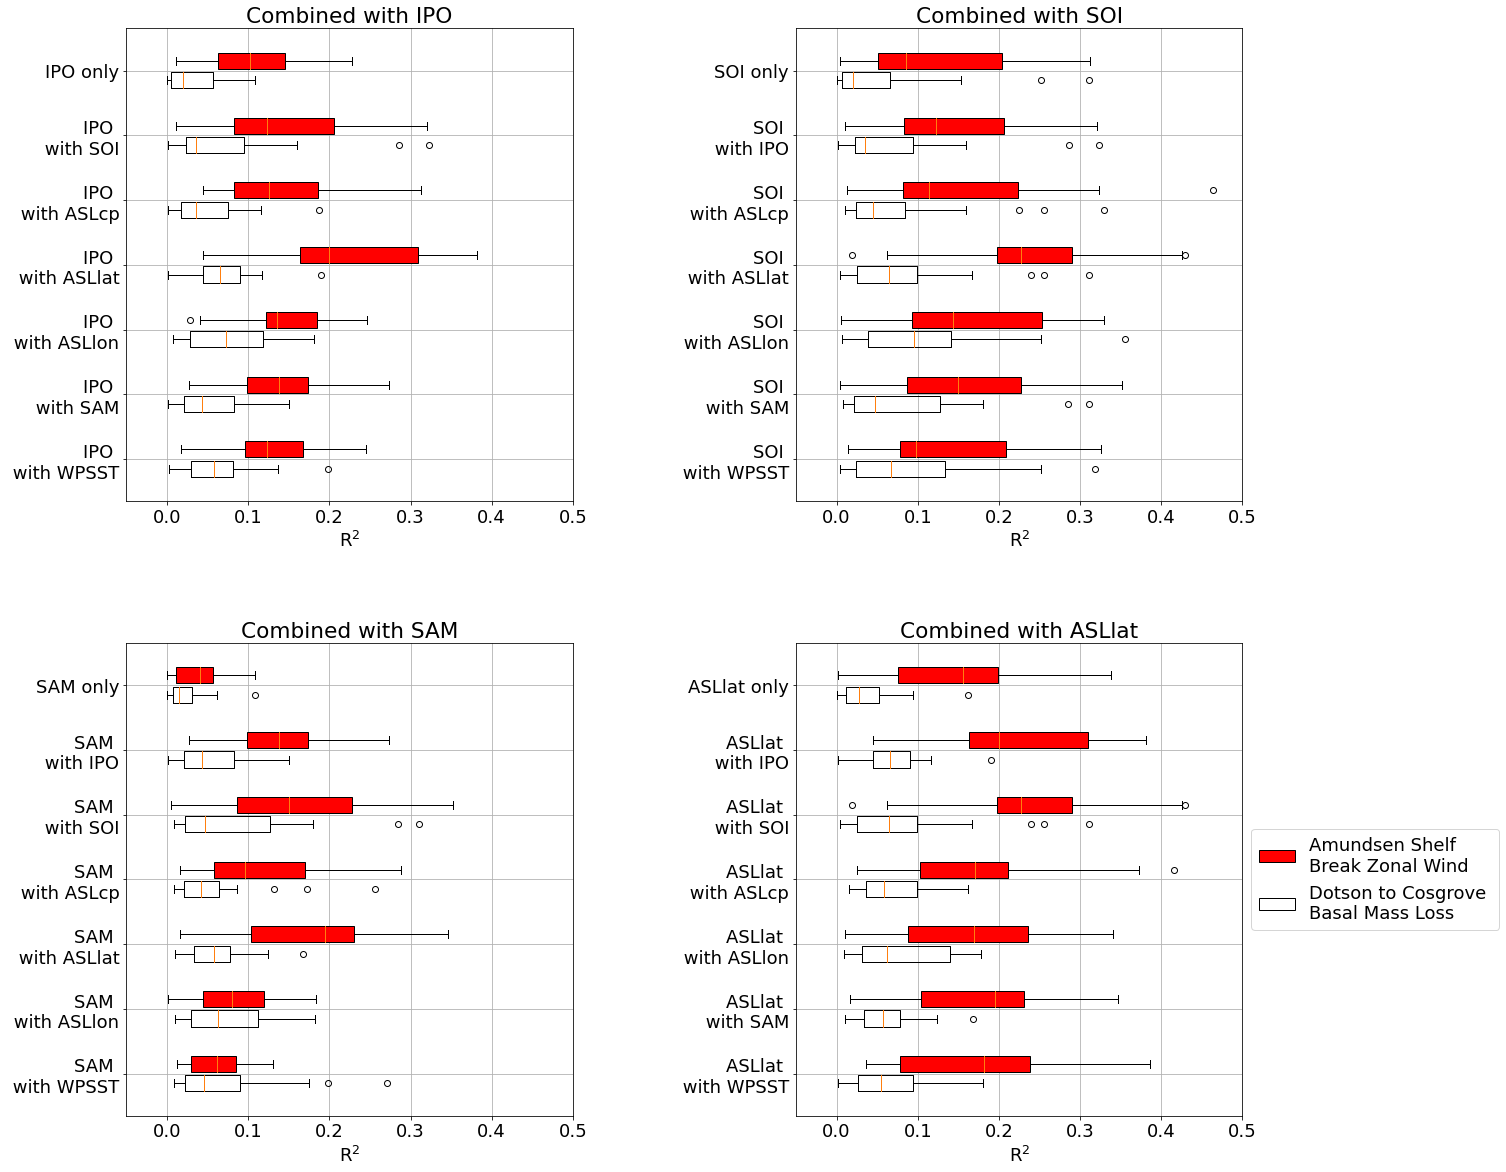

In [204]:
#Show how well they work together, can unfortunately only be used for R^2

plt.rcParams.update({'font.size': 18})
fig=plt.figure(figsize=(20,20))

for nr, base_ind in enumerate(['IPO', 'SOI', 'SAM', 'ASLlat']):
    plt.subplot(2,2,nr+1)
    corrs_wind, corrs_melt=correlate_with_base_ind(base_ind=base_ind)

    names=np.array([i for i in corrs_melt.keys()], dtype=object)
    j=0
    for i in range(len(names)):
        if names[i]==base_ind:
            names[i]=base_ind+' only'
            j=i
        else:
            names[i]=base_ind+' \n with '+names[i]
    
    idx=[j]
    for i in range(len(names)):
        if names[i]!=base_ind+' only':
            idx+=[i]


    names=names[idx][::-1]
    data_melt=np.array([corrs_melt[j] for j in corrs_melt])[idx][::-1].T
    data_wind=np.array([corrs_wind[j] for j in corrs_wind])[idx][::-1].T

    a=plt.boxplot(data_melt, positions=np.arange(len(names))+0.85, widths=0.25, vert=False)
    b=plt.boxplot(data_wind, positions=np.arange(len(names))+1.15, widths=0.25, vert=False, patch_artist=True)
    plt.yticks(np.arange(len(names))+1, names)
    plt.grid()
    plt.title('Combined with '+base_ind)
    plt.xlabel('R$^2$')
    plt.xlim([-0.05,0.5])

    # fill with colors
    colors = ['r',]*len(names)
    #for bplot in (bplot1, bplot2):
    for patch, color in zip(b['boxes'], colors):
        patch.set_facecolor(color)

plt.subplots_adjust(hspace=0.3, wspace=0.5)
import matplotlib.patches as mpatches
white_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='Dotson to Cosgrove \nBasal Mass Loss')
red_patch = mpatches.Patch(facecolor='red', edgecolor='black', label='Amundsen Shelf \nBreak Zonal Wind')
lgd=plt.legend(handles=[red_patch, white_patch], loc='center left', bbox_to_anchor=(1, 0.5))

## What defines members with strong ENSO events?

In [1]:
#Print high melt members
# a=melt['dotson_to_cosgrove_massloss'].sel(time=slice('1940', '1941')).mean(dim='time')-melt['dotson_to_cosgrove_massloss'].sel(time=slice('1938', '1939')).mean(dim='time')
# a.ens.sortby(a)

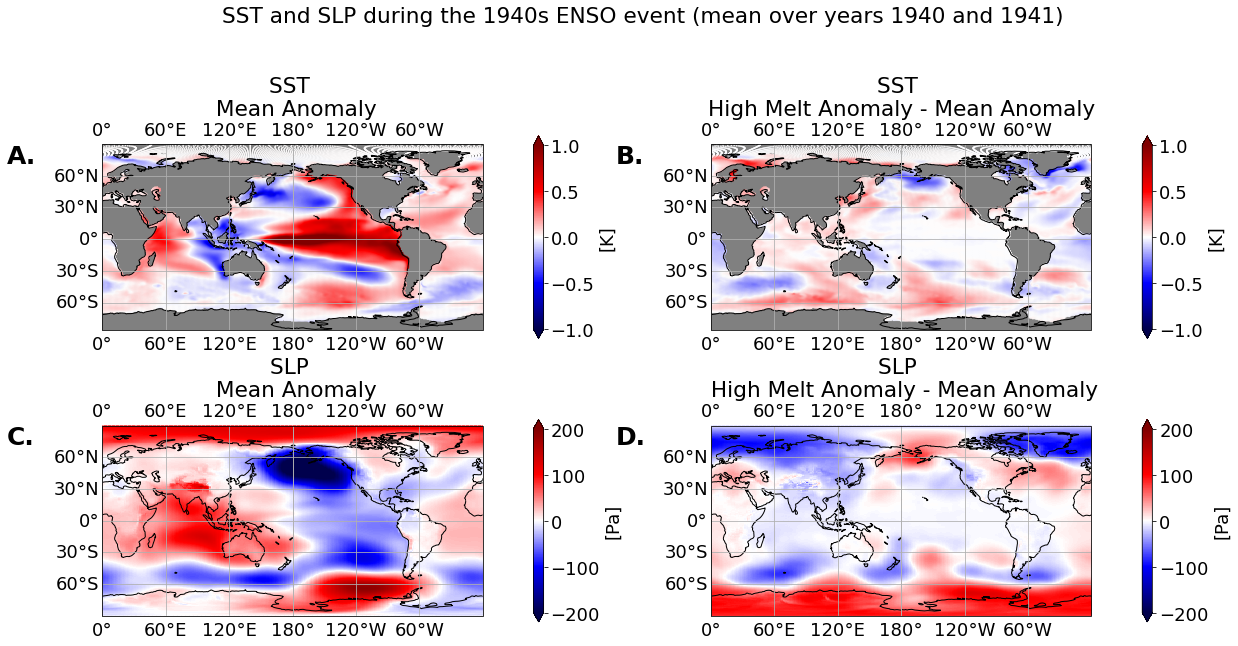

In [9]:
#Maps showing the difference between high melt members (HMMs) and the ensemble mean for the 1940s

plt.rcParams.update({'font.size': 18})
import cartopy.crs as ccrs

ens_list=[ 9,  2,  7, 16,  5] #Members to choose for high melt (based on 1940s)

years=['1940', '1941'] #Years to take the time-mean over

fig=plt.figure(figsize=(20,10))
plt.suptitle('SST and SLP during the 1940s ENSO event (time mean over years '+str(years[0])+' and '+str(years[1])+')')

#Show the ensemble-mean 1940s SST
ax = plt.subplot(221, projection=ccrs.PlateCarree(central_longitude=180.0))
unit='[K]'
img=ax.scatter(SST_dt.ULONG.to_numpy().flatten(), SST_dt.ULAT.to_numpy().flatten(), s=0.3,
                c=SST_dt.isel(z_t=0).sel(time=slice(years[0], years[1])).mean(dim=['time', 'ens']).to_numpy().flatten(), 
                cmap='seismic', transform=ccrs.PlateCarree(), vmin=-1, vmax=1)
ax.set_facecolor('grey')
plt.colorbar(img, label=unit, pad=0.10, ax=ax, extend='both')
ax.coastlines()
ax.set_title('SST \n Mean Anomaly')
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

#Show the HHM 1940s - ensemble mean for SST
ax = plt.subplot(222, projection=ccrs.PlateCarree(central_longitude=180.0))

img=ax.scatter(SST_dt.ULONG.to_numpy().flatten(), SST_dt.ULAT.to_numpy().flatten(), s=0.3,
               c=SST_dt.isel(z_t=0).sel(time=slice(years[0], years[1]), ens=ens_list).mean(dim=['time', 'ens']).to_numpy().flatten()-SST_dt.isel(z_t=0).sel(time=slice(years[0], years[1])).mean(dim=['time', 'ens']).to_numpy().flatten(), 
               cmap='seismic', transform=ccrs.PlateCarree(), vmin=-1, vmax=1)
ax.set_facecolor('grey')
plt.colorbar(img, label=unit, pad=0.10, ax=ax, extend='both')
ax.coastlines()
ax.set_title('SST \nHigh Melt Anomaly - Mean Anomaly')
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())


#Show the ensemble-mean 1940s SLP
unit='[Pa]'
ax = plt.subplot(223, projection=ccrs.PlateCarree(central_longitude=180.0))

img=ax.pcolor(PSL_dt.lon, PSL_dt.lat,
              PSL_dt.sel(time=slice(years[0], years[1])).mean(dim=['time', 'ens']).values, 
              cmap='seismic', transform=ccrs.PlateCarree(), vmin=-200, vmax=200)
ax.set_facecolor('grey')
plt.colorbar(img, label=unit, pad=0.10, ax=ax, extend='both')
ax.coastlines()
ax.set_title('SLP \n Mean Anomaly')
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())


#Show the HHM 1940s - ensemble mean for SLP
ax = plt.subplot(224, projection=ccrs.PlateCarree(central_longitude=180.0))

img=ax.pcolor(PSL_dt.lon, PSL_dt.lat,
              PSL_dt.sel(time=slice(years[0], years[1]), ens=ens_list).mean(dim=['time', 'ens']).values- PSL_dt.sel(time=slice(years[0], years[1])).mean(dim=['time', 'ens']).values, 
              cmap='seismic', transform=ccrs.PlateCarree(), vmin=-200, vmax=200)
ax.set_facecolor('grey')
plt.colorbar(img, label=unit, pad=0.10, ax=ax, extend='both')
ax.coastlines()
ax.set_title('SLP \n High Melt Anomaly - Mean Anomaly')
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

plt.subplots_adjust(top=0.8, hspace=0.4, wspace=0.2)

#Add letter next to plot
import string
for n, ax in enumerate(fig.axes[::2]):
        ax.text(-0.25, 0.9, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
            size=25, weight='bold')

plt.savefig('/data/hpcdata/users/grejan/mitgcm/03_output/other/new_fff_1940s.png')

### What do the indices do in the 1940s?

In [31]:
#Normalize the indices in the 1940s.
ASLcp1940s=(ASLcp.sel(time=slice('1940', '1941')).mean(dim='time')-ASLcp.mean(dim='time'))/ASLcp.std(dim='time')
ASLlon1940s=(ASLlon.sel(time=slice('1940', '1941')).mean(dim='time')-ASLlon.mean(dim='time'))/ASLlon.std(dim='time')
ASLlat1940s=(ASLlat.sel(time=slice('1940', '1941')).mean(dim='time')-ASLlat.mean(dim='time'))/ASLlat.std(dim='time')
IPO1940s=(IPO.sel(time=slice('1940', '1941')).mean(dim='time')-IPO.mean(dim='time'))/IPO.std(dim='time')
SOI1940s=(SOI.sel(time=slice('1940', '1941')).mean(dim='time')-SOI.mean(dim='time'))/SOI.std(dim='time')
#AMO1940s=AMO.sel(time=slice('1940', '1941')).mean(dim='time')
WPSST1940s=(WPSST.sel(time=slice('1940', '1941')).mean(dim='time')-WPSST.mean(dim='time'))/WPSST.std(dim='time')
SAM1940s=(SAM.sel(time=slice('1940', '1941')).mean(dim='time')-SAM.mean(dim='time'))/SAM.std(dim='time')

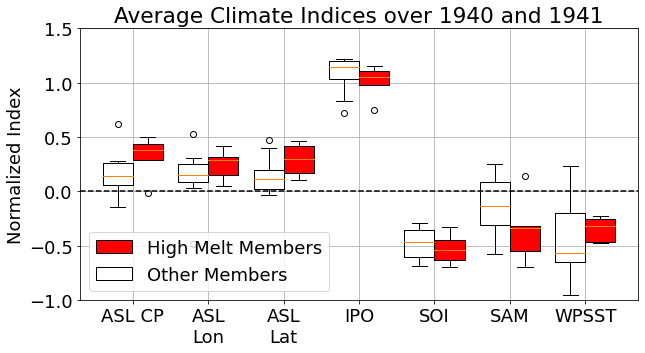

In [33]:
#Plot Box Plot of Normalized Indices in 1940s.
plt.figure(figsize=(10,5))

a=np.arange(20)

#Create a list with members not in the HMMs
no_ens_list=[]
for i in a:
    if i not in ens_list:
        no_ens_list+=[i]

#data=np.vstack([ASLcp1940s, ASLlon1940s, ASLlat1940s, IPO1940s, SOI1940s, SAM1940s, WPSST1940s])
dataHM=np.vstack([ASLcp1940s.sel(ens=ens_list), ASLlon1940s.sel(ens=ens_list), ASLlat1940s.sel(ens=ens_list), \
                  IPO1940s.sel(ens=ens_list), SOI1940s.sel(ens=ens_list), SAM1940s.sel(ens=ens_list), WPSST1940s.sel(ens=ens_list), \
                  ])

dataLM=np.vstack([ASLcp1940s.sel(ens=no_ens_list), ASLlon1940s.sel(ens=no_ens_list), ASLlat1940s.sel(ens=no_ens_list), \
                  IPO1940s.sel(ens=no_ens_list), SOI1940s.sel(ens=no_ens_list), SAM1940s.sel(ens=no_ens_list), 
                  WPSST1940s.sel(ens=no_ens_list), \
                  ])

#data=data.T
names=['ASL CP', 'ASL\nLon', 'ASL\nLat', 'IPO', 'SOI', 'SAM', 'WPSST']
    
plt.subplot(1,1,1)
box1=plt.boxplot(dataLM.T, vert=True, positions=np.arange(len(names))+0.8, widths=0.4)
box2=plt.boxplot(dataHM.T, vert=True, positions=np.arange(len(names))+1.2, widths=0.4, patch_artist=True)
#box2=plt.boxplot(dataHM, vert=False, positions=np.arange(len(dataHM))+1.5)#, patch_artist=True)
plt.xticks(np.arange(len(names))+1, names)
plt.grid()
plt.title('Average Climate Indices over 1940 and 1941')
plt.ylabel('Normalized Index')
plt.ylim([-1,1.5])
plt.axhline(y = 0, color = 'k', ls='--')
# fill with colors
colors = ['r',]*len(names)
#for bplot in (bplot1, bplot2):
for patch, color in zip(box2['boxes'], colors):
    patch.set_facecolor(color)

import matplotlib.patches as mpatches
white_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='Other Members ')
red_patch = mpatches.Patch(facecolor='red', edgecolor='black', label='High Melt Members')
plt.legend(handles=[red_patch, white_patch])

plt.savefig('/data/hpcdata/users/grejan/mitgcm/03_output/other/climateindices_1940s.png')

### BONUS

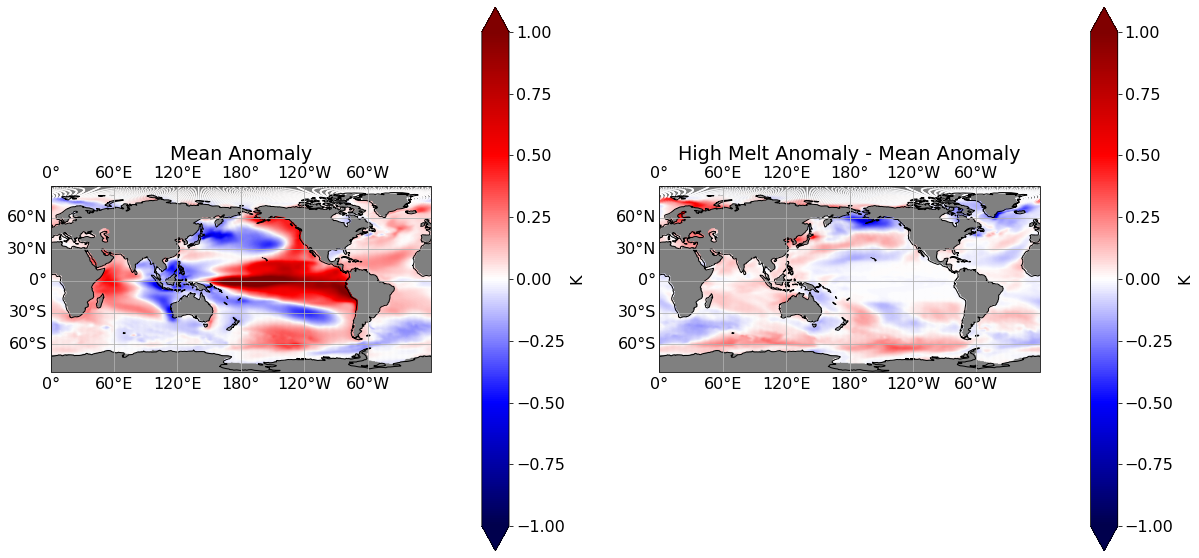

In [165]:
import cartopy.crs as ccrs
unit='K'
#ens_list=[2,5,9,8,16]
#ens_list=[9,5,13,2,16]
#ens_list=np.array([11, 12, 6, 10, 4])-1


years=['1940', '1941']

fig=plt.figure(figsize=(20,10))
ax = plt.subplot(121, projection=ccrs.PlateCarree(central_longitude=180.0))
if 'K' in unit:
    img=ax.scatter(SST_dt.ULONG.to_numpy().flatten(), SST_dt.ULAT.to_numpy().flatten(), s=0.3,
                  c=SST_dt.isel(z_t=0).sel(time=slice(years[0], years[1])).mean(dim=['time', 'ens']).to_numpy().flatten(), 
                  cmap='seismic', transform=ccrs.PlateCarree(), vmin=-1, vmax=1)
if 'Pa' in unit:
    img=ax.pcolor(PSL_dt.lon, PSL_dt.lat,
                  PSL_dt.sel(time=slice(years[0], years[1])).mean(dim=['time', 'ens']).values, 
                  cmap='seismic', transform=ccrs.PlateCarree(), vmin=-200, vmax=200)
ax.set_facecolor('grey')
plt.colorbar(img, label=unit, pad=0.10, ax=ax, extend='both')
ax.coastlines()
ax.set_title('Mean Anomaly')
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

ax = plt.subplot(122, projection=ccrs.PlateCarree(central_longitude=180.0))
if 'K' in unit:
    img=ax.scatter(SST_dt.ULONG.to_numpy().flatten(), SST_dt.ULAT.to_numpy().flatten(), s=0.3,
                  c=SST_dt.isel(z_t=0).sel(time=slice(years[0], years[1]), ens=ens_list).mean(dim=['time', 'ens']).to_numpy().flatten()-SST_dt.isel(z_t=0).sel(time=slice(years[0], years[1])).mean(dim=['time', 'ens']).to_numpy().flatten(), 
                  cmap='seismic', transform=ccrs.PlateCarree(), vmin=-1, vmax=1)
if 'Pa' in unit:
    img=ax.pcolor(PSL_dt.lon, PSL_dt.lat,
                  PSL_dt.sel(time=slice(years[0], years[1]), ens=ens_list).mean(dim=['time', 'ens']).values- PSL_dt.sel(time=slice(years[0], years[1])).mean(dim=['time', 'ens']).values, 
                  cmap='seismic', transform=ccrs.PlateCarree(), vmin=-200, vmax=200)
ax.set_facecolor('grey')
plt.colorbar(img, label=unit, pad=0.10, ax=ax, extend='both')
ax.coastlines()
ax.set_title('High Melt Anomaly - Mean Anomaly')
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())



In [108]:
#Simple or Fancy Correlation Map
SST_dt=detrend_and_average_MITgcmData(SST, 'SST', window=60)
PSL_dt=detrend_and_average_MITgcmData(PSL, 'PSL', window=60)
melt_dt=detrend_and_average_MITgcmData(melt, 'dotson_to_cosgrove_massloss', window=60)

In [117]:
res=xr.corr(PSL_dt, melt_dt, dim='time')

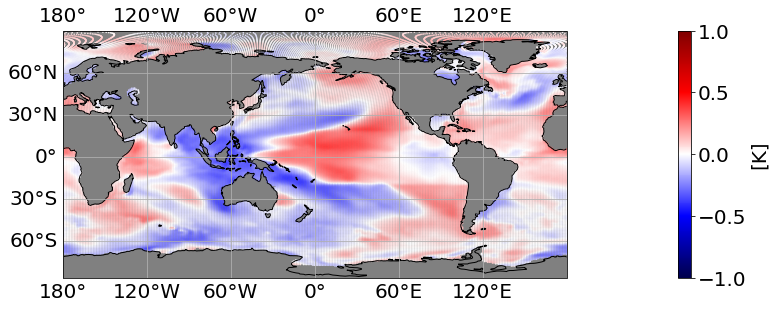

In [116]:
unit='[K]'
import cartopy.crs as ccrs
fig=plt.figure(figsize=(20,10))
ax = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180.0))
if 'Pa' in unit:
    img=ax.pcolormesh(mean1.lon, mean1.lat, 
                  mean1.values, 
                  cmap='seismic', transform=ccrs.PlateCarree(), vmin=-80, vmax=80)
elif 'K' in unit:
    img=ax.scatter(res.TLONG.to_numpy().flatten(), res.TLAT.to_numpy().flatten(), s=0.3,
                  c=res.isel(z_t=0).mean(dim='ens').to_numpy().flatten(), 
                  cmap='seismic', transform=ccrs.PlateCarree(), vmin=-1, vmax=1)
ax.set_facecolor('grey')
plt.colorbar(img, label=unit, pad=0.10, ax=ax)
ax.coastlines()
#ax.set_title(title+'\n melt>90th percentile')
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())


/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'c'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


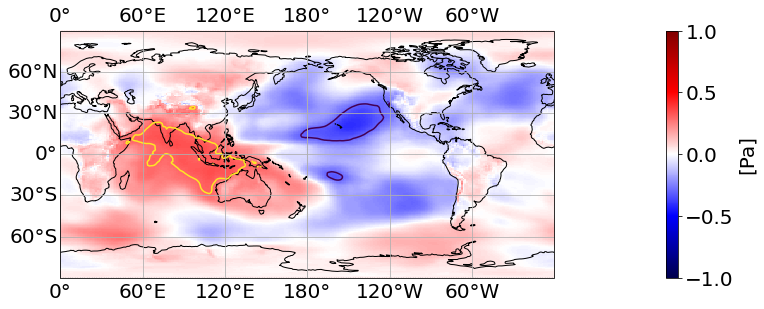

In [124]:
unit='[Pa]'
import cartopy.crs as ccrs
fig=plt.figure(figsize=(20,10))
ax = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180.0))
if 'Pa' in unit:
    img=ax.pcolormesh(res.lon, res.lat, 
                  res.mean(dim='ens').values, 
                  cmap='seismic', transform=ccrs.PlateCarree(), vmin=-1, vmax=1)
    ax.contour(res.lon, res.lat, 
                  res.mean(dim='ens').values, levels=[-0.3, 0.3], c=['yellow', 'yellow'],
                  transform=ccrs.PlateCarree())
elif 'K' in unit:
    img=ax.scatter(res.TLONG.to_numpy().flatten(), res.TLAT.to_numpy().flatten(), s=0.3,
                  c=res.isel(z_t=0).mean(dim='ens').to_numpy().flatten(), 
                  cmap='seismic', transform=ccrs.PlateCarree(), vmin=-1, vmax=1)
ax.set_facecolor('grey')
plt.colorbar(img, label=unit, pad=0.10, ax=ax)
ax.coastlines()
#ax.set_title(title+'\n melt>90th percentile')
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

In [ ]:
#Create a new correlation map for PACE

In [33]:
def correlationMapPACE(members='all',
                      data=None, datavar='PSL',
                      ind=None, indfn='timeseries_final', indvar='dotson_to_cosgrove_massloss', lags=range(-24, 0),
                      years=['1920', '2013'],
                      detrend=True, deseasonalize=True, window=24, title='2D Correlation Map', ymax=-70, 
                      save=False, savefn='test',
                      draw_box=False, box_x=[360-115, 360-102],box_y=[-71.8, -70.2],
                      inverse=False, save_results=True, give_back=False, cumsum_map=False, cumsum_ind=False):
    '''
    Input: Only one map
    New: using xskillscore
    
    '''
    
    print('Start preparing for correlation map!')
    print('NOTE: this is version 3!')
    plt.rcParams.update({'font.size': 14})
    if members=='all':
        members=[0,20]
    
    data_og=data
    ind_og=ind
    for ens in range(members[0]+1,members[-1]+1):
        #First, we read the data!
        if type(data_og)==type(None):
                print('...Reading: '+datavar+'...')
                data=loadPACEData(datavar, members=[ens-1, ens]) 
        if datavar=='SST':
            data=data.isel(z_t=0)
        
        if type(ind_og)==type(None):
            print('...Reading: '+indfn)
            if 'timeseries' in indfn:
                ind=loadTimeSeriesData(filename=indfn, members=[ens-1, ens], kind='old')
            else:        
                ind=xr.open_dataarray('/data/hpcdata/users/grejan/mitgcm/02_data/indices/'+indfn+'.nc')
                if members!='all':
                    print('...Selecting member '+str(members[0]+1))
                    ind=ind.sel(ens=[members[0]])
                ind=ind.to_dataset()

        #Selecting the proper years:
        print('...Selecting times between: '+str(years[0])+' and '+str(years[-1]))
        data=data.sel(time=slice(years[0], years[-1]))
        ind=ind.sel(time=slice(years[0], years[-1]))
        

        if detrend==True:
            print('...Detrending data')
            data=detrend_and_average_MITgcmData(data, var=datavar, window=1)
            ind=detrend_and_average_MITgcmData(ind, var=indvar, window=1)
        
        #print(np.shape(ind.values))
        #This step was necessary because for some reason 1920-01 was not contained in the PACE output (?)
        if len(ind.time)!=len(data.time):
            ind=ind[:,1:]
        
        if deseasonalize==True:
            print('...Deseasonalizing the data')
            monthlymean=data.groupby('time.month').mean("time")
            data=data.groupby('time.month')-monthlymean
            
            monthlymean=ind.groupby('time.month').mean("time")
            ind=ind.groupby('time.month')-monthlymean
    
        if cumsum_map==True:
            data=data.cumsum(dim='time')
        if cumsum_ind==True:
            ind=ind.cumsum(dim='time')
        
        if window!=1:
            print('...Applying rolling mean')
            data=data.rolling(time=window, center=True).mean()
            ind=ind.rolling(time=window, center=True).mean()

        print('...Computing correlation coefficients')

        data=data.stack(ens_time=['ens', 'time'])
        for z, lag in enumerate(lags):
            print('...Looking at lag: '+str(lag))
            ind_temp=ind.shift(time=lag) #Positive means index is leading!
            ind_temp=ind_temp.stack(ens_time=['ens', 'time'])
            
#             print(ind_temp.ens_time)
#             print(data.ens_time)
            
            if detrend==True:
                res_temp=xs.pearson_r(data, ind_temp, dim='ens_time', skipna=True)
                p_temp=xs.pearson_r_p_value(data, ind_temp, dim='ens_time', skipna=True)
            else:
                res_temp=xs.pearson_r(data[datavar], ind_temp[indvar], dim='ens_time', skipna=True)
                p_temp=xs.pearson_r_p_value(data[datavar], ind_temp[indvar], dim='ens_time', skipna=True)

            if z==0:
                res=res_temp
                p=p_temp

            else:
                res=xr.concat([res, res_temp], dim='lag')
                p=xr.concat([p, p_temp], dim='lag')

        print('...Plotting')
        fig=plt.figure(figsize=(20,12))


        fig.suptitle(title+'\n Ensemble Member '+ str(ens)+'; ('+str(window)+' month running mean); p<0.05')

        if inverse==True:
            print('...NOTE: Taking the INVERSE of the correlation!')
            res=-1*res

        maxcor=res.max(dim='lag')
        mincor=res.min(dim='lag')
        maxp=p.min(dim='lag')

        maxcor=maxcor.where((maxp<=0.05) | (np.isnan(maxp)), other=0)
        mincor=mincor.where((maxp<=0.05) | (np.isnan(maxp)), other=0)

#         print(np.shape(maxcor))
#         print(np.shape(mincor))
        
        
#         print(np.shape(maxcor.to_numpy()))
#         print(np.shape(maxcor<abs(mincor)))
#         print('Yes')
#         print(np.shape(maxcor.to_numpy()[maxcor<abs(mincor)]))
        
        
        maxcor.to_numpy()[maxcor<abs(mincor)]=mincor.to_numpy()[maxcor<abs(mincor)]

        import cartopy.crs as ccrs
        #fig=plt.figure(figsize=(20,10))
        ax = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180.0))
        if 'PSL' in datavar:
            img=ax.pcolormesh(res.lon, res.lat, 
                          maxcor, 
                          cmap='seismic', transform=ccrs.PlateCarree(), vmin=-1, vmax=1)
            ax.contour(res.lon, res.lat, 
                          maxcor, levels=[-0.5, 0.5], c=['yellow', 'yellow'],
                          transform=ccrs.PlateCarree())
        elif 'SST' in datavar:
            img=ax.scatter(res.TLONG.to_numpy().flatten(), res.TLAT.to_numpy().flatten(), s=0.3,
                          c=maxcor.to_numpy().flatten(), 
                          cmap='seismic', transform=ccrs.PlateCarree(), vmin=-1, vmax=1)
        ax.set_facecolor('grey')
        plt.colorbar(img, label='Correlation Coefficient', pad=0.10, ax=ax)
        ax.coastlines()
        ax.set_title('Optimal correlation coefficient')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        

        print('...Finding optimal lag')
        idx=np.argmax([i=='lag' for i in res.dims])
        masked=np.ma.masked_invalid(res.where((maxp<=0.05) & (maxp>=0)).to_numpy())
        opt_lag=np.nanargmax(abs(masked), axis=idx)
        opt_lag=opt_lag.astype(float)
        opt_lag[masked.mask.max(axis=idx)]=np.nan
        opt_lag=opt_lag+lags[0]

        ax = plt.subplot(212, projection=ccrs.PlateCarree(central_longitude=180.0))
        if 'PSL' in datavar:
            img=ax.pcolormesh(res.lon, res.lat, 
                          opt_lag, 
                          cmap='seismic', transform=ccrs.PlateCarree(), vmin=lags[0], vmax=lags[-1])
#             ax.contour(res.lon, res.lat, 
#                           res.mean(dim='ens').values, levels=[-0.3, 0.3], c=['yellow', 'yellow'],
#                           transform=ccrs.PlateCarree())
        elif 'SST' in datavar:
            img=ax.scatter(res.TLONG.to_numpy().flatten(), res.TLAT.to_numpy().flatten(), s=0.3,
                          c=opt_lag.flatten(), 
                          cmap='seismic', transform=ccrs.PlateCarree(), vmin=lags[0], vmax=lags[-1])
        ax.set_facecolor('grey')
        plt.colorbar(img, label='Optimal Lag [months]', pad=0.10, ax=ax)
        ax.coastlines()
        ax.set_title('Optimal lag \n (positive=time series leading)')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
    
        fig.subplots_adjust(hspace=0.4)

        if save==True:
            print('...Saving figure')
            from datetime import date
            today = date.today()
            today=today.strftime("%Y%m%d")
            #if members=='all':
            #    fig.savefig('../03_output/correlation/'+today+'_1Dcormap_'+savefn+'_all.png')
            #else:
            fig.savefig('../03_output/correlation/'+today+'_PACEcormap_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_member'+str(ens)+'.png')

        if save_results==True:
            if cumsum_map==True:
                print('Saving cumsum')
                np.save('../02_data/correlation/opt_lag_cum'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.npy', opt_lag)
                maxp.to_netcdf('../02_data/correlation/maxp_cum'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                maxcor.to_netcdf('../02_data/correlation/maxcor_cum'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')

            else:
                np.save('../02_data/correlation/opt_lag_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.npy', opt_lag)
                maxp.to_netcdf('../02_data/correlation/maxp_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                maxcor.to_netcdf('../02_data/correlation/maxcor_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')

    return
  

Start preparing for correlation map!
NOTE: this is version 3!
...Reading: SST...
Loading number:1
...Reading: timeseries_final
Loading number:1
../data/timeseries_final_PACE02.nc
...Selecting times between: 1920 and 2013
...Detrending data
...Deseasonalizing the data
...Applying rolling mean
...Computing correlation coefficients
...Looking at lag: -2
...Looking at lag: -1
...Plotting
(384, 320)
(384, 320)
(384, 320)
(384, 320)
Yes
(24986,)
...Finding optimal lag
Saving cumsum


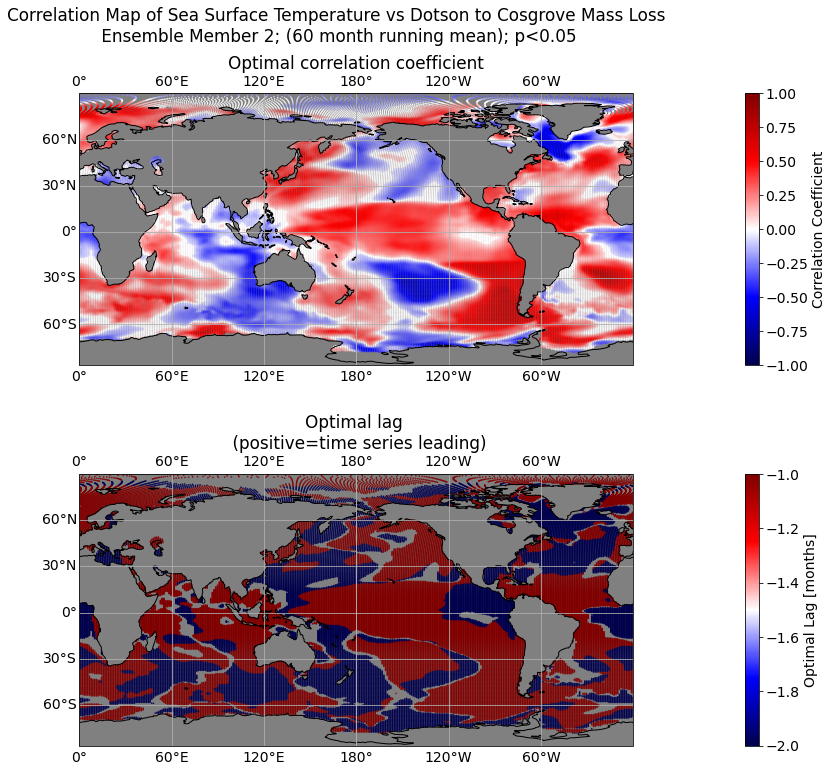

In [39]:
# correlationMapPACE(members=[1,2], datavar='PSL', 
#                    lags=range(-2, 0), window=60,
#                    title='Correlation Map of Surface Air Pressure vs Dotson to Cosgrove Mass Loss')

correlationMapPACE(members=[1,2], datavar='SST', cumsum_map=True,
                   lags=range(-2, 0), window=60,
                   title='Correlation Map of Sea Surface Temperature vs Dotson to Cosgrove Mass Loss')

In [20]:
def showMapPACE(members='all',
              data=None, datavar='PSL',
              ind=None, indfn='timeseries_final', indvar='dotson_to_cosgrove_massloss', lags=range(-24, 0),
              years=['1920', '2013'],
              detrend=True, deseasonalize=True, window=24, title='2D Correlation Map', ymax=-70, 
              save=False, savefn='test',
              draw_box=False, box_x=[360-115, 360-102],box_y=[-71.8, -70.2],
              inverse=False, save_results=True, give_back=False, cumsum_map=False, cumsum_ind=False):
    '''
    Input: Always give U component as input!
    
    '''
    from mitgcm_python_master.grid import ERA5Grid, PACEGrid, Grid, dA_from_latlon, pierre_obs_grid
    from scipy import stats
    
    print('Start preparing for correlation map!')
    print('NOTE: this is version 3!')
    plt.rcParams.update({'font.size': 22})
    
    if members=='all':
        members=[0,20]
    
    length=members[-1]-members[0]
    
    for i, ens in enumerate(range(members[0]+1,members[-1]+1)):
        if deseasonalize==True:
            if cumsum_map==True:
                try:
                    temp_opt_lag=np.load('../02_data/correlation/2D_opt_lag_cum'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.npy')
                    #temp_maxp=xr.open_dataarray('../02_data/correlation/2D_maxp_cum'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                    temp_maxcor=xr.open_dataarray('../02_data/correlation/2D_maxcor_cum'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                except:
                    temp_opt_lag=np.load('../02_data/correlation/opt_lag_cum'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.npy')
                    #temp_maxp=xr.open_dataarray('../02_data/correlation/maxp_cum'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                    temp_maxcor=xr.open_dataarray('../02_data/correlation/maxcor_cum'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
            else:
                try:
                    temp_opt_lag=np.load('../02_data/correlation/2D_opt_lag_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.npy')
                    #temp_maxp=xr.open_dataarray('../02_data/correlation/2D_maxp_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                    temp_maxcor=xr.open_dataarray('../02_data/correlation/2D_maxcor_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                except:
                    temp_opt_lag=np.load('../02_data/correlation/opt_lag_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.npy')
                    #temp_maxp=xr.open_dataarray('../02_data/correlation/maxp_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                    temp_maxcor=xr.open_dataarray('../02_data/correlation/maxcor_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
        else:
            try:
                temp_opt_lag=np.load('../02_data/correlation/2D_opt_lag_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_w'+str(window)+'_ens'+str(ens)+'.npy')
                #temp_maxp=xr.open_dataarray('../02_data/correlation/2D_maxp_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                temp_maxcor=xr.open_dataarray('../02_data/correlation/2D_maxcor_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
            except:
                try:
                    temp_opt_lag=np.load('../02_data/correlation/opt_lag_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_w'+str(window)+'_ens'+str(ens)+'.npy')
                    #temp_maxp=xr.open_dataarray('../02_data/correlation/maxp_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                    temp_maxcor=xr.open_dataarray('../02_data/correlation/maxcor_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                except:
                    temp_opt_lag=np.load('../02_data/correlation/2D_opt_lag_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.npy')
                    #temp_maxp=xr.open_dataarray('../02_data/correlation/2D_maxp_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                    temp_maxcor=xr.open_dataarray('../02_data/correlation/2D_maxcor_'+datavar+'_'+indvar+'_dt'+str(detrend)+'_dS'+str(deseasonalize)+'_w'+str(window)+'_ens'+str(ens)+'.nc')
                    
        if i==0:
            opt_lag=temp_opt_lag
            #maxp=temp_maxp
            maxcor=temp_maxcor
        else:
            opt_lag=np.dstack((opt_lag, temp_opt_lag))
            #maxp=xr.concat([maxp, temp_maxp], dim='ens')
            maxcor=xr.concat([maxcor, temp_maxcor], dim='ens')
    if i==0:
        #maxp=maxp.expand_dims('ens')
        maxcor=maxcor.expand_dims('ens')

    
    #stdp=maxp.mean(dim='ens')
    maxp=stats.ttest_1samp(maxcor, popmean=0)[1]
    if length>1:
        opt_lag_p_pos=stats.ttest_1samp(opt_lag, axis=2, popmean=0, alternative='greater')[1]
        opt_lag_p_neg=stats.ttest_1samp(opt_lag, axis=2, popmean=0, alternative='less')[1]
    
    stdcor=maxcor.std(dim='ens')
    maxcor=maxcor.mean(dim='ens')
    if length!=1:
        std_lag=np.nanstd(opt_lag, axis=2)
        opt_lag=np.nanmean(opt_lag, axis=2)
    else:
        std_lag=np.zeros(np.shape(opt_lag))
    
    #maxcor=maxcor.where(maxcor!=0, other=np.nan)
    if length!=1:
        maxcor=maxcor.where((maxp<0.05) | maxcor.isnull(), other=0)
        opt_lag[(opt_lag_p_pos>0.05)&(opt_lag_p_neg>0.05)]=0
        
    #Reading Grid
    gp='/data/oceans_output/shelf/kaight/mitgcm/PAS_grid/'
    grid = Grid(gp)
    
    print('...Plotting')
    #fig, ax=plt.subplots(2,1, figsize=(20,14))
    fig=plt.figure(figsize=(20,14))
    
    if members[-1]==21:
        fig.suptitle(title+'\n Ensemble Mean; '+str(window)+' month rolling mean; p<0.05')
    else:
        fig.suptitle(title+'\n Mean over members '+ str(members[0]+1)+' to '+ str(members[-1])+'; '+str(window)+' month rolling mean; p<0.05')


    #PLOT CORRELATION COEFFICIENTS
    import cartopy.crs as ccrs
    ax = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180.0))
    
    if 'PSL' in datavar:
        img=ax.pcolormesh(maxcor.lon, maxcor.lat, 
                      maxcor, 
                      cmap='seismic', transform=ccrs.PlateCarree(), vmin=-1, vmax=1)
        CS=ax.contour(maxcor.lon, maxcor.lat, 
                      maxcor, levels=[-0.5, 0.5], colors='yellow',
                      transform=ccrs.PlateCarree())
        ax.clabel(CS, CS.levels, inline=True,fontsize=10)
        
    elif 'SST' in datavar:
        img=ax.scatter(maxcor.ULONG.to_numpy().flatten(), maxcor.ULAT.to_numpy().flatten(), s=0.3,
                      c=maxcor.to_numpy().flatten(), 
                      cmap='seismic', transform=ccrs.PlateCarree(), vmin=-1, vmax=1)
    ax.set_facecolor('grey')
    plt.colorbar(img, label='Correlation Coefficient', pad=0.10, ax=ax)
    ax.coastlines()
    ax.set_title('Optimal correlation coefficient')
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
  

    #PLOT OPTIMAL LAG
    ax = plt.subplot(212, projection=ccrs.PlateCarree(central_longitude=180.0))
    if 'PSL' in datavar:
        img=ax.pcolormesh(maxcor.lon, maxcor.lat, 
                      opt_lag, 
                      cmap='seismic', transform=ccrs.PlateCarree(), vmin=lags[0], vmax=lags[-1])
#             ax.contour(res.lon, res.lat, 
#                           res.mean(dim='ens').values, levels=[-0.3, 0.3], c=['yellow', 'yellow'],
#                           transform=ccrs.PlateCarree())
    elif 'SST' in datavar:
        img=ax.scatter(maxcor.ULONG.to_numpy().flatten(), maxcor.ULAT.to_numpy().flatten(), s=0.3,
                      c=opt_lag.flatten(), 
                      cmap='seismic', transform=ccrs.PlateCarree(), vmin=lags[0], vmax=lags[-1])
    ax.set_facecolor('grey')
    plt.colorbar(img, label='Optimal Lag [months]', pad=0.10, ax=ax)
    ax.coastlines()
    ax.set_title('Optimal lag \n (positive=time series leading)')
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
    
    fig.subplots_adjust(hspace=0.5, top=0.85)

    if save==True:
        print('...Saving figure')
        from datetime import date
        today = date.today()
        today=today.strftime("%Y%m%d")
        fig.savefig('../03_output/correlation/'+today+'_PACE_cormap_'+datavar+'_'+indvar+'_members'+str(members[0])+'-'+str(members[-1])+'.png')
    
    if length!=1:
        if 'PSL' in datavar:
            fig=plt.figure(figsize=(20,10))
            plt.suptitle('Extra statistics over ensemble members for : \n'+title)
            plt.subplot(2,3,1)
            img=plt.pcolor(maxcor.lon, maxcor.lat, maxp, vmax=0.05, cmap='seismic')
            plt.colorbar(img, label='P value')
            #CS=plt.contour(maxp.XC, maxp.YC, maxp, [1e-4], colors='yellow')
            #plt.clabel(CS, CS.levels, inline=True,fontsize=10)
            plt.title('P value, corr!=0')# \n Yellow line indicates 1e-4')

            plt.subplot(2,3,2)
            img=plt.pcolor(maxcor.lon, maxcor.lat, opt_lag_p_pos, vmin=0, vmax=0.05, cmap='seismic')
            plt.colorbar(img, label='P value')
            #CS=plt.contour(stdp.XC, stdp.YC, stdp, [1e-4], colors='yellow')
            #plt.clabel(CS, CS.levels, inline=True,fontsize=10)
            plt.title('P value, lag>0')# \n Yellow line indicates 1e-4')

            plt.subplot(2,3,3)
            img=plt.pcolor(maxcor.lon, maxcor.lat, opt_lag_p_neg, vmin=0, vmax=0.05, cmap='seismic')
            plt.colorbar(img, label='P value')
            #CS=plt.contour(stdp.XC, stdp.YC, stdp, [1e-4], colors='yellow')
            #plt.clabel(CS, CS.levels, inline=True,fontsize=10)
            plt.title('P value, lag<0')# \n Yellow line indicates 1e-4')

            plt.subplot(2,2,3)
            img=plt.pcolor(stdcor.lon, stdcor.lat, stdcor, cmap='seismic', vmax=0.3)
            plt.colorbar(img, label='Std of cor')
            #CS=plt.contour(stdcor.XC, stdcor.YC, stdcor, [0.1], colors='yellow')
            #plt.clabel(CS, CS.levels, inline=True,fontsize=10)
            plt.title('Standard deviation of correlation coefficient')#  \n Yellow line indicates 0.1')

            plt.subplot(2,2,4)
            img=plt.pcolor(stdcor.lon, stdcor.lat, std_lag, cmap='seismic', vmax=10)
            plt.colorbar(img, label='Std of lag')
            #CS=plt.contour(stdcor.XC, stdcor.YC, std_lag, [4], colors='yellow')
            #plt.clabel(CS, CS.levels, inline=True,fontsize=10)
            plt.title('Standard deviation of lag')# \n Yellow line indicates 4 months')

            fig.subplots_adjust(hspace=0.5, wspace=0.3, top=0.8)

        elif 'SST' in datavar:
            fig=plt.figure(figsize=(20,10))
            plt.suptitle('Extra statistics over ensemble members for : \n'+title)
            plt.subplot(2,3,1)
            img=plt.scatter(maxcor.ULONG.to_numpy().flatten(), maxcor.ULAT.to_numpy().flatten(), s=0.3,
                          c=maxp.flatten(), 
                          cmap='seismic', vmin=0, vmax=0.05)
            plt.colorbar(img, label='P value')
            #CS=plt.contour(maxp.XC, maxp.YC, maxp, [1e-4], colors='yellow')
            #plt.clabel(CS, CS.levels, inline=True,fontsize=10)
            plt.title('P value, corr!=0')# \n Yellow line indicates 1e-4')

            plt.subplot(2,3,2)
            img=plt.scatter(maxcor.ULONG.to_numpy().flatten(), maxcor.ULAT.to_numpy().flatten(), s=0.3,
                          c=opt_lag_p_pos.flatten(), 
                          cmap='seismic', vmin=0, vmax=0.05)
            #img=plt.pcolor(maxcor.lon, maxcor.lat, opt_lag_p_pos, vmin=0, vmax=0.05, cmap='seismic')
            plt.colorbar(img, label='P value')
            #CS=plt.contour(stdp.XC, stdp.YC, stdp, [1e-4], colors='yellow')
            #plt.clabel(CS, CS.levels, inline=True,fontsize=10)
            plt.title('P value, lag>0')# \n Yellow line indicates 1e-4')

            plt.subplot(2,3,3)
            img=plt.scatter(maxcor.ULONG.to_numpy().flatten(), maxcor.ULAT.to_numpy().flatten(), s=0.3,
                          c=opt_lag_p_neg.flatten(), 
                          cmap='seismic', vmin=0, vmax=0.05)
            #img=plt.pcolor(maxcor.lon, maxcor.lat, opt_lag_p_neg, vmin=0, vmax=0.05, cmap='seismic')
            plt.colorbar(img, label='P value')
            #CS=plt.contour(stdp.XC, stdp.YC, stdp, [1e-4], colors='yellow')
            #plt.clabel(CS, CS.levels, inline=True,fontsize=10)
            plt.title('P value, lag<0')# \n Yellow line indicates 1e-4')

            plt.subplot(2,2,3)
            img=plt.scatter(maxcor.ULONG.to_numpy().flatten(), maxcor.ULAT.to_numpy().flatten(), s=0.3,
                          c=stdcor.to_numpy().flatten(), 
                          cmap='seismic', vmax=0.3)
            #img=plt.pcolor(stdcor.lon, stdcor.lat, stdcor, cmap='seismic', vmax=0.3)
            plt.colorbar(img, label='Std of cor')
            #CS=plt.contour(stdcor.XC, stdcor.YC, stdcor, [0.1], colors='yellow')
            #plt.clabel(CS, CS.levels, inline=True,fontsize=10)
            plt.title('Standard deviation of correlation coefficient')#  \n Yellow line indicates 0.1')

            plt.subplot(2,2,4)
            img=plt.scatter(maxcor.ULONG.to_numpy().flatten(), maxcor.ULAT.to_numpy().flatten(), s=0.3,
                          c=std_lag.flatten(), 
                          cmap='seismic', vmax=10)
            #img=plt.pcolor(stdcor.lon, stdcor.lat, std_lag, cmap='seismic', vmax=10)
            plt.colorbar(img, label='Std of lag')
            #CS=plt.contour(stdcor.XC, stdcor.YC, std_lag, [4], colors='yellow')
            #plt.clabel(CS, CS.levels, inline=True,fontsize=10)
            plt.title('Standard deviation of lag')# \n Yellow line indicates 4 months')

            fig.subplots_adjust(hspace=0.5, wspace=0.3, top=0.8)

        if save==True:
            print('...Saving second figure')
            from datetime import date
            today = date.today()
            today=today.strftime("%Y%m%d")
            fig.savefig('../03_output/correlation/'+today+'_PACE_BONUS_2Dcormap_'+datavar+'_'+indvar+'_members'+str(members[0])+'-'+str(members[-1])+'.png')

    return

Start preparing for correlation map!
NOTE: this is version 3!
...Plotting


/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


...Saving figure
...Saving second figure


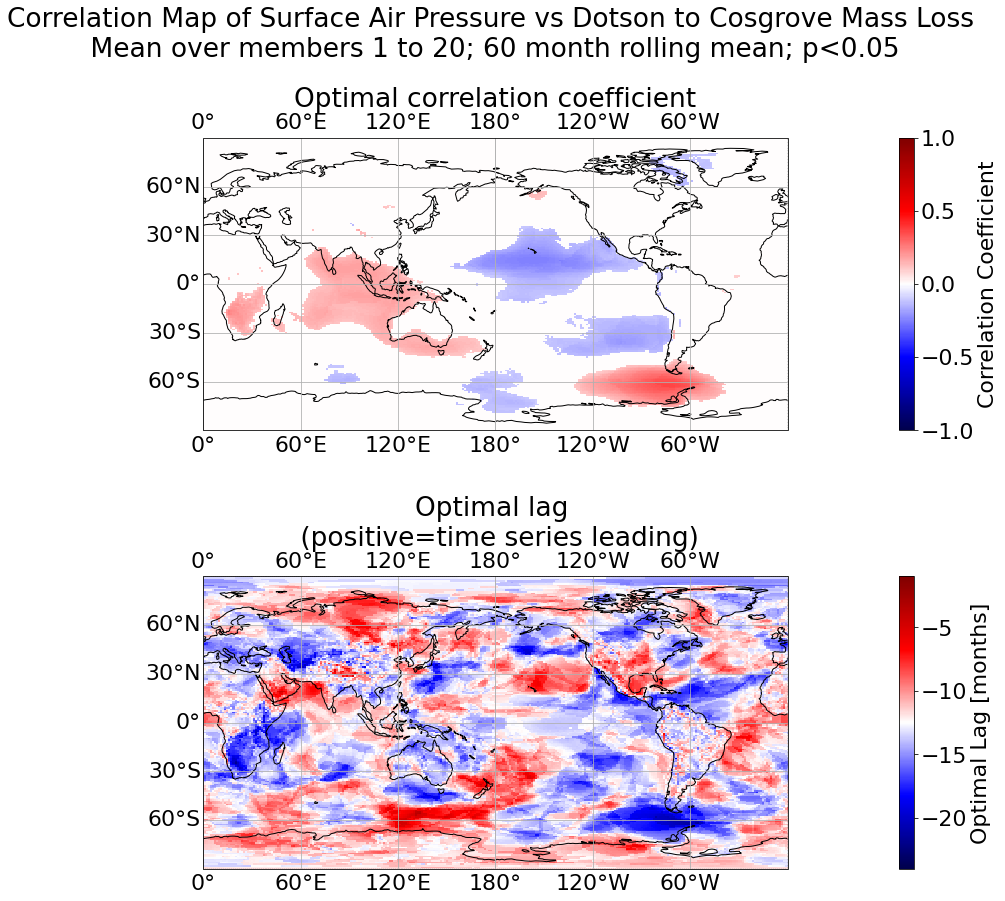

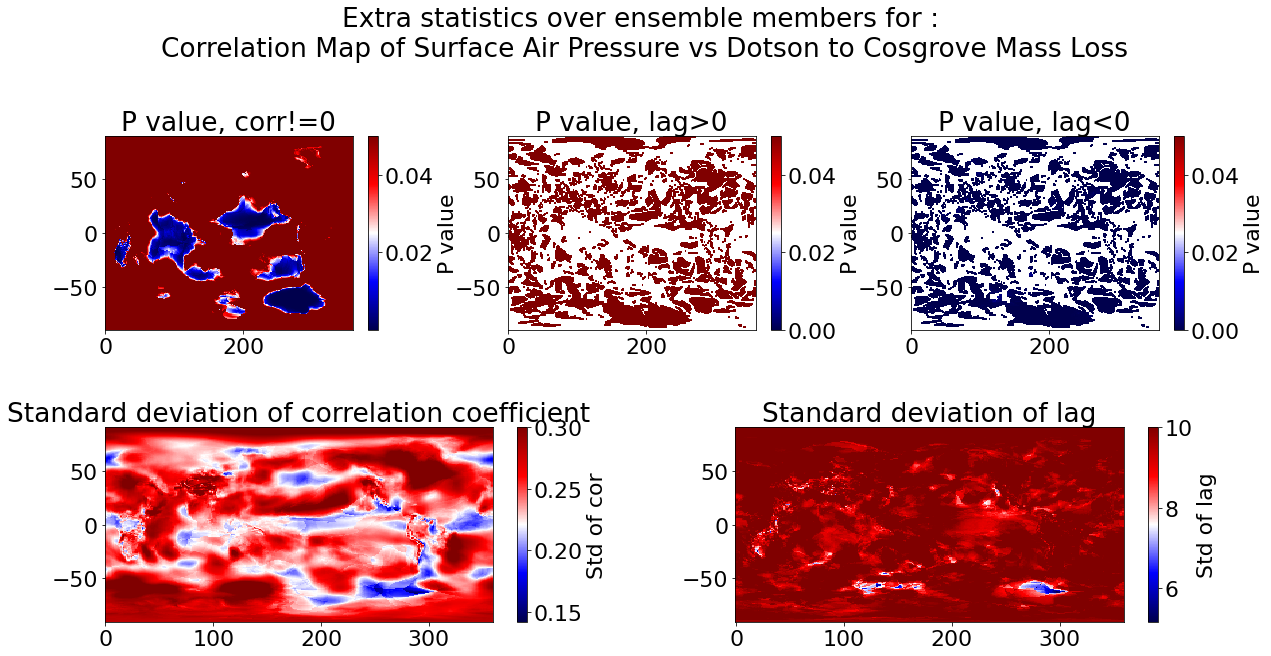

In [6]:
showMapPACE(members='all', datavar='PSL', 
                   lags=range(-24, 0), window=60, save=True,
                   title='Correlation Map of Surface Air Pressure vs Dotson to Cosgrove Mass Loss')

Start preparing for correlation map!
NOTE: this is version 3!


/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


...Plotting


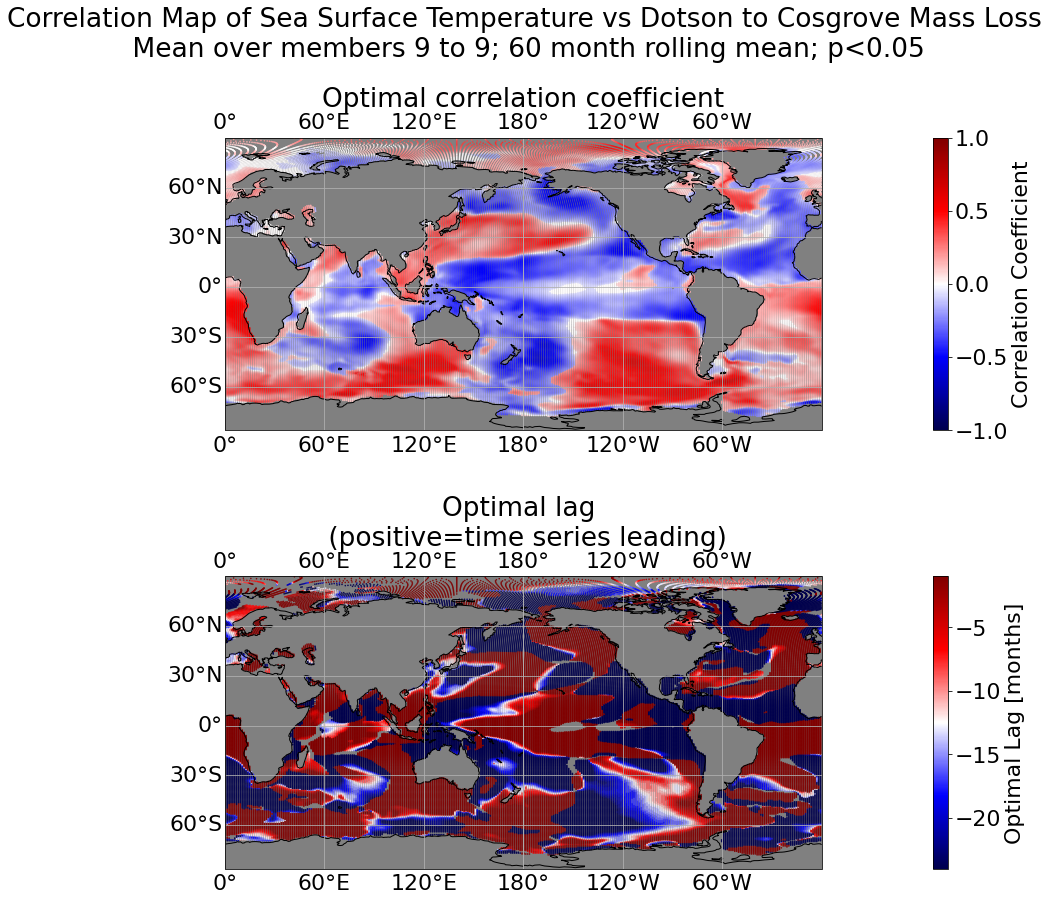

In [29]:
showMapPACE(members=[8,9], datavar='SST', 
                   lags=range(-24, 0), window=60, save=False,
                   title='Correlation Map of Sea Surface Temperature vs Dotson to Cosgrove Mass Loss')

In [ ]:
import cartopy.crs as ccrs
def plotGlobalMap(data_dt, var,  year, ax_nr=331, title='Sea Level Pressure', unit='[Pa]', cbar=False):
    ax = plt.subplot(ax_nr, projection=ccrs.PlateCarree(central_longitude=180.0))
    data_dt[var]=data_dt[var].where(data_dt[var]!=0)
    divnorm = colors.TwoSlopeNorm(vcenter=0, vmin=np.nanpercentile(data_dt[var], 1), vmax=np.nanpercentile(data_dt[var], 99))
    img=ax.pcolor(data_dt[var].lon, data_dt[var].lat, 
                  data_dt[var].sel(time=year).values, 
                  cmap='seismic', norm=divnorm, transform=ccrs.PlateCarree())
    ax.set_facecolor('grey')
    if cbar:
        plt.colorbar(img, label=unit, ax=ax, pad=0.15)
    ax.coastlines()
    ax.set_title(title)
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(central_longitude=180.0))

    return
   
year=-4
plt.figure(figsize=(20,10))
plotGlobalMap(data_dt=data_new, var='PSL', ax_nr=331, year=year, title='Sea Level Pressure', unit='[Pa]', cbar=True)

In [129]:
import xskillscore as xs

In [35]:
members=[0,1]
PSL=loadPACEData(var='PSL', members=members)
SST=loadPACEData(var='SST', members=members) 

Loading number:0
Loading number:0


In [37]:
SST.TLAT[]

<xarray.DataArray 'TLAT' (nlat: 384, nlon: 320)>
array([[-79.22052261, -79.22052261, -79.22052261, ..., -79.22052261,
        -79.22052261, -79.22052261],
       [-78.68630626, -78.68630626, -78.68630626, ..., -78.68630626,
        -78.68630626, -78.68630626],
       [-78.15208992, -78.15208992, -78.15208992, ..., -78.15208992,
        -78.15208992, -78.15208992],
       ...,
       [ 71.29031715,  71.29408252,  71.30160692, ...,  71.30160692,
         71.29408252,  71.29031716],
       [ 71.73524335,  71.73881845,  71.74596231, ...,  71.74596231,
         71.73881845,  71.73524335],
       [ 72.18597561,  72.18933231,  72.19603941, ...,  72.19603941,
         72.18933231,  72.18597562]])
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  array of t-grid latitudes
    units:      degrees_north

In [ ]:
dataU=dataU.interp(XC=data.TLONG, YC=data.YC)